In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.morphology import dilation, square
from itertools import product
import geopandas as gpd
import cf_xarray as cfxr
from shapely.geometry import Point

In [3]:
import sys
import os

In [4]:
from utils import (
    RCM_DICT,
    MODEL_DICT,
    RLAT_NAMES,
    RLON_NAMES,
)

from urban_areas import (
    load_fixed_variables,
    fix_sftuf,
#    select_name,
    Urban_vicinity,
    load_variable,
    kelvin2degC,
    load_ucdb_city,
)

from GHCNd_stations import (
    load_ghcnd_stations,
    get_ghcnd_df,
    get_valid_timeseries,
    available_vars,
)

from plot_functions import (
    plot_climatology,
    plot_time_series
)

### Define urban areas and vicinity

##### Define model and data directory

In [5]:
domain = 'EUR-11'
model = 'REMO' # REMO/RegCM
scenario = 'evaluation'
variable = 'tasmin'
root_esgf = '/lustre/gmeteo/DATA/ESGF/REPLICA/DATA/cordex/output/'
root_nextcloud = '/lustre/gmeteo/WORK/DATA/CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/'

##### Input parameters

In [6]:
#lon_city = 2.35 
#lat_city = 48.85
lon_city = -0.13
lat_city = 51.50
urban_th = 0.1
urban_sur_th = 0.1
orog_diff = 100
sftlf_th = 70
scale = 2
lon_lim = 0.7
lat_lim = 0.7

In [7]:
# domain resolution
res = int(domain.split('-')[1])

##### Load fixed variables

In [8]:
ds_sftuf, ds_orog, ds_sftlf = load_fixed_variables(domain, model, root_esgf, root_nextcloud)
# fix some issues for sftuf
ds_sftuf = fix_sftuf(domain, model, ds_sftuf, ds_orog, ds_sftlf)

##### Add parameters to the function

In [9]:
URBAN = Urban_vicinity(
    urban_th, 
    urban_sur_th, 
    orog_diff, 
    sftlf_th,
    scale,
    lon_city,
    lat_city,
    lon_lim,
    lat_lim)

##### Crop area around de city

In [10]:
ds_sftuf = URBAN.crop_area_city(ds_sftuf, res)
ds_orog = URBAN.crop_area_city(ds_orog, res)
ds_sftlf = URBAN.crop_area_city(ds_sftlf, res)

##### Define masks

In [11]:
# define masks
sftuf_mask, sftuf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sftuf, 
    ds_orog, 
    ds_sftlf
)

##### Plot masks

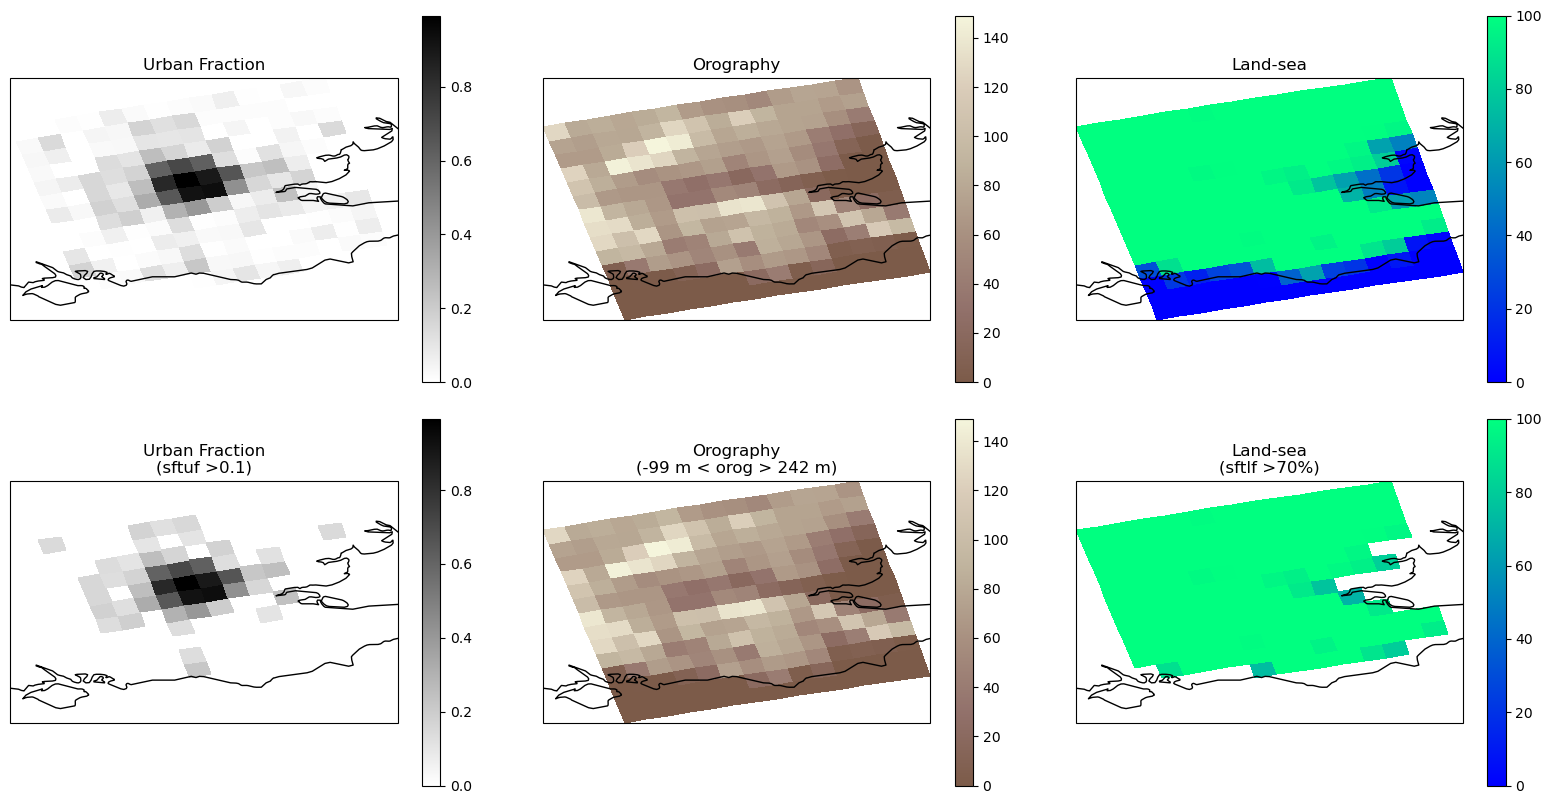

In [12]:
# plot mask
fig = URBAN.plot_fixed_variables(ds_sftuf, ds_orog, ds_sftlf,
                                 sftuf_mask, orog_mask, sftlf_mask)

#### Define rural vicinity areas

In [13]:
urban_vicinity = URBAN.select_urban_vicinity(
    sftuf_mask, 
    orog_mask,
    sftlf_mask,
    sftuf_sur_mask
)

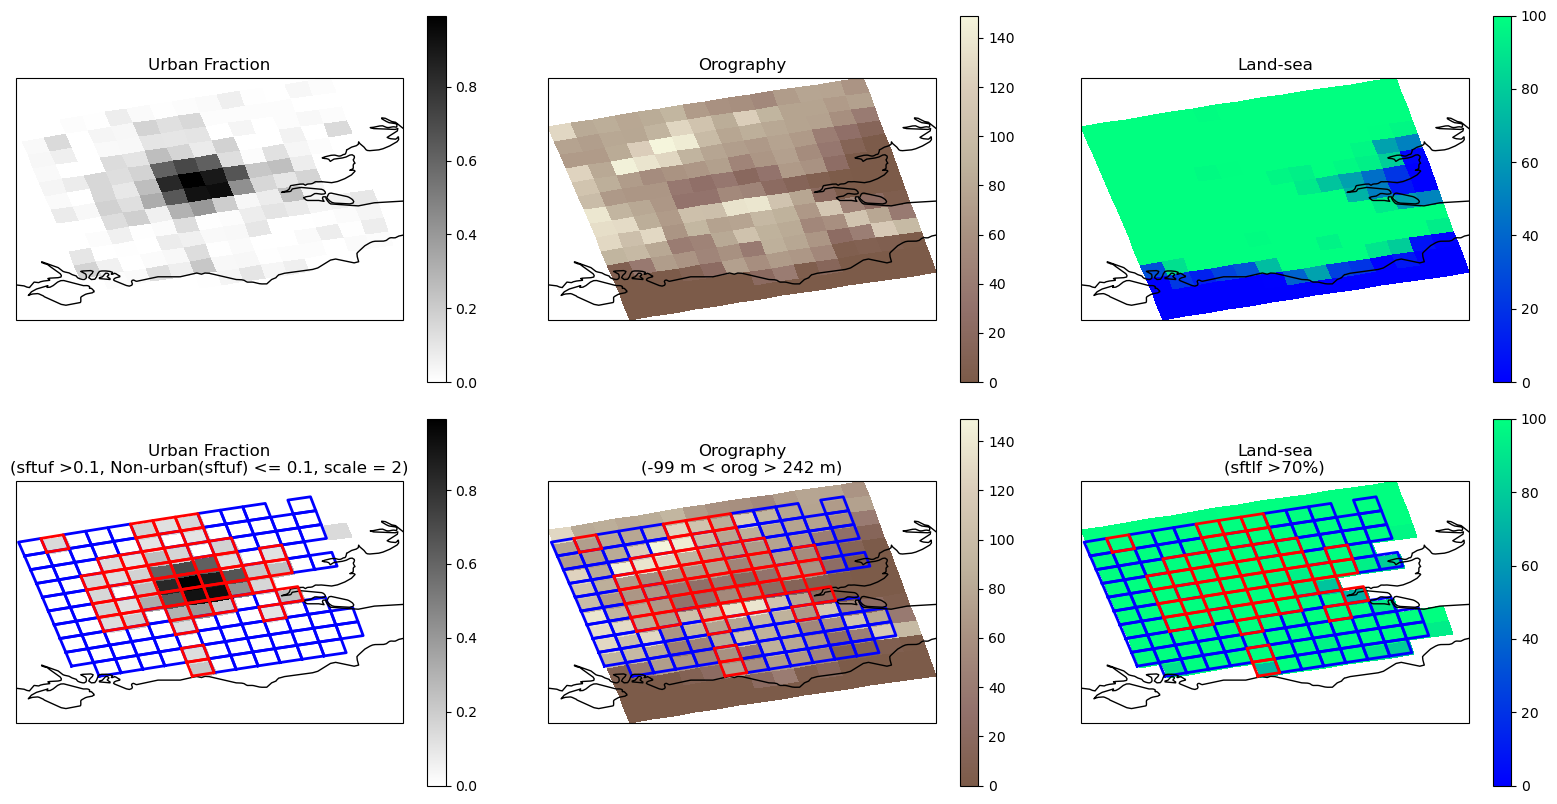

In [14]:
# plot mask and urban vs vicinity
fig = URBAN.plot_fixed_variables(ds_sftuf, ds_orog, ds_sftlf,
                                 sftuf_mask, orog_mask, sftlf_mask,
                                 urban_vicinity)

# Calculate Heat urban effect

In [15]:
variable = 'tasmin'
city = 'London'
observations = True

#### Load city shapefile

In [16]:
ucdb_city = load_ucdb_city(root_nextcloud, city)

#### Load variable from ESGF DRS

In [17]:
# load variablep
ds_var = load_variable(root_esgf, variable, domain, model, scenario)
# convert to degC
ds_var = kelvin2degC(ds_var, variable)
# crop area
ds_var=URBAN.crop_area_city(ds_var,res)

#### Load observations

In [18]:
obs=load_ghcnd_stations(lon_city, lat_city)

/vols/abedul/home/meteo/quintanay/GHCNd_stations.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  rval = ghcnd_stations.assign(dist = ghcnd_stations.distance(Point(lon, lat)))


#### Select coincident period between Model and Observations

In [19]:
valid_stations, time_series, ds_var_period = get_valid_timeseries(city, obs, ds_var, variable, idate='1990-01-01')

London -- HAMPSTEAD, UK - TMIN has 99.2% valid records in 1990-01-01 to 2014-12-31
London -- HEATHROW, UK - TMIN has no valid records in 1990-01-01 to 2014-12-31


/vols/abedul/home/meteo/quintanay/GHCNd_stations.py:88: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{city} -- {stn_data.NAME[0]} - {var} has {100*valid_records:.1f}% valid records in {idate} to {fdate}')
/vols/abedul/home/meteo/quintanay/GHCNd_stations.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{city} -- {stn_data.NAME[0]} - {var} has no valid records in {idate} to {fdate}')


#### Compute climatology (rural annomaly)

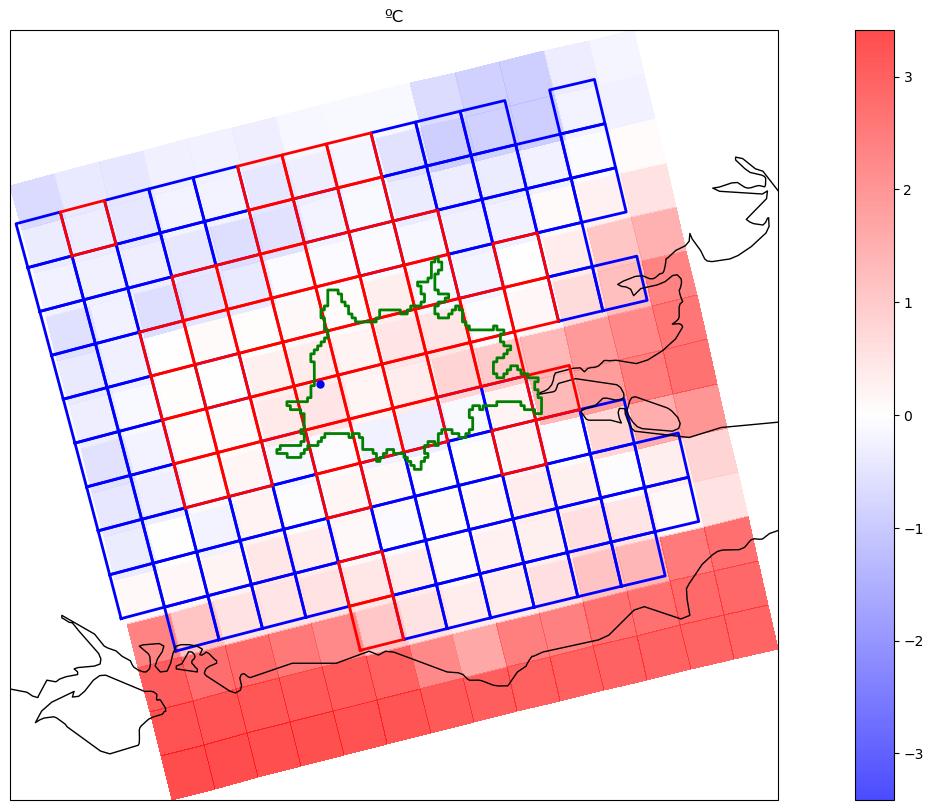

In [20]:
fig=plot_climatology(ds_var_period, ucdb_city,urban_vicinity,variable, URBAN,obs)


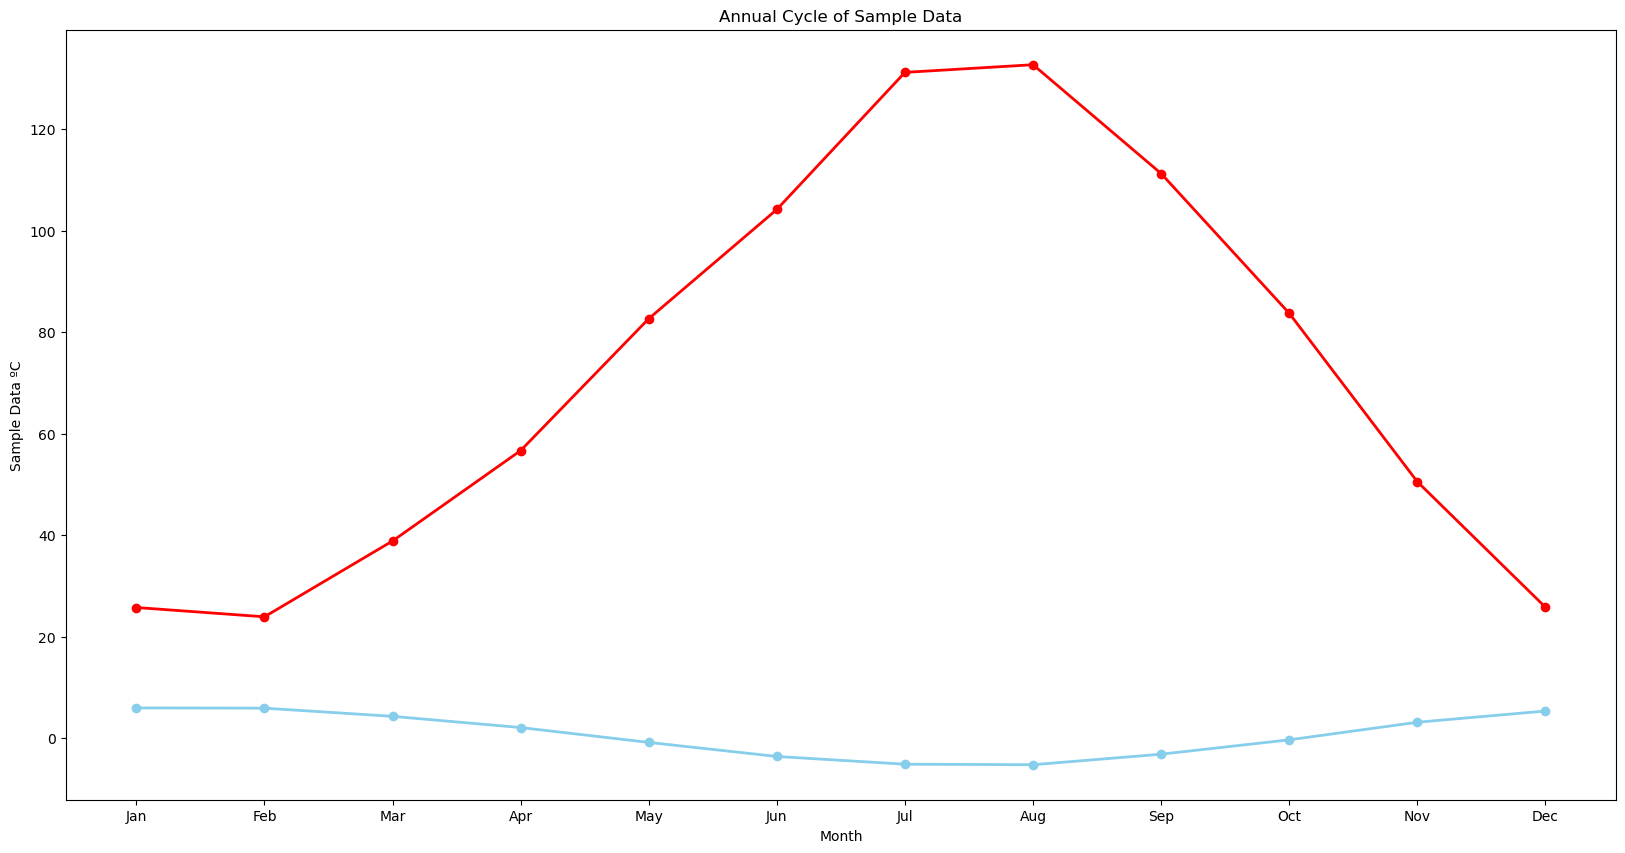

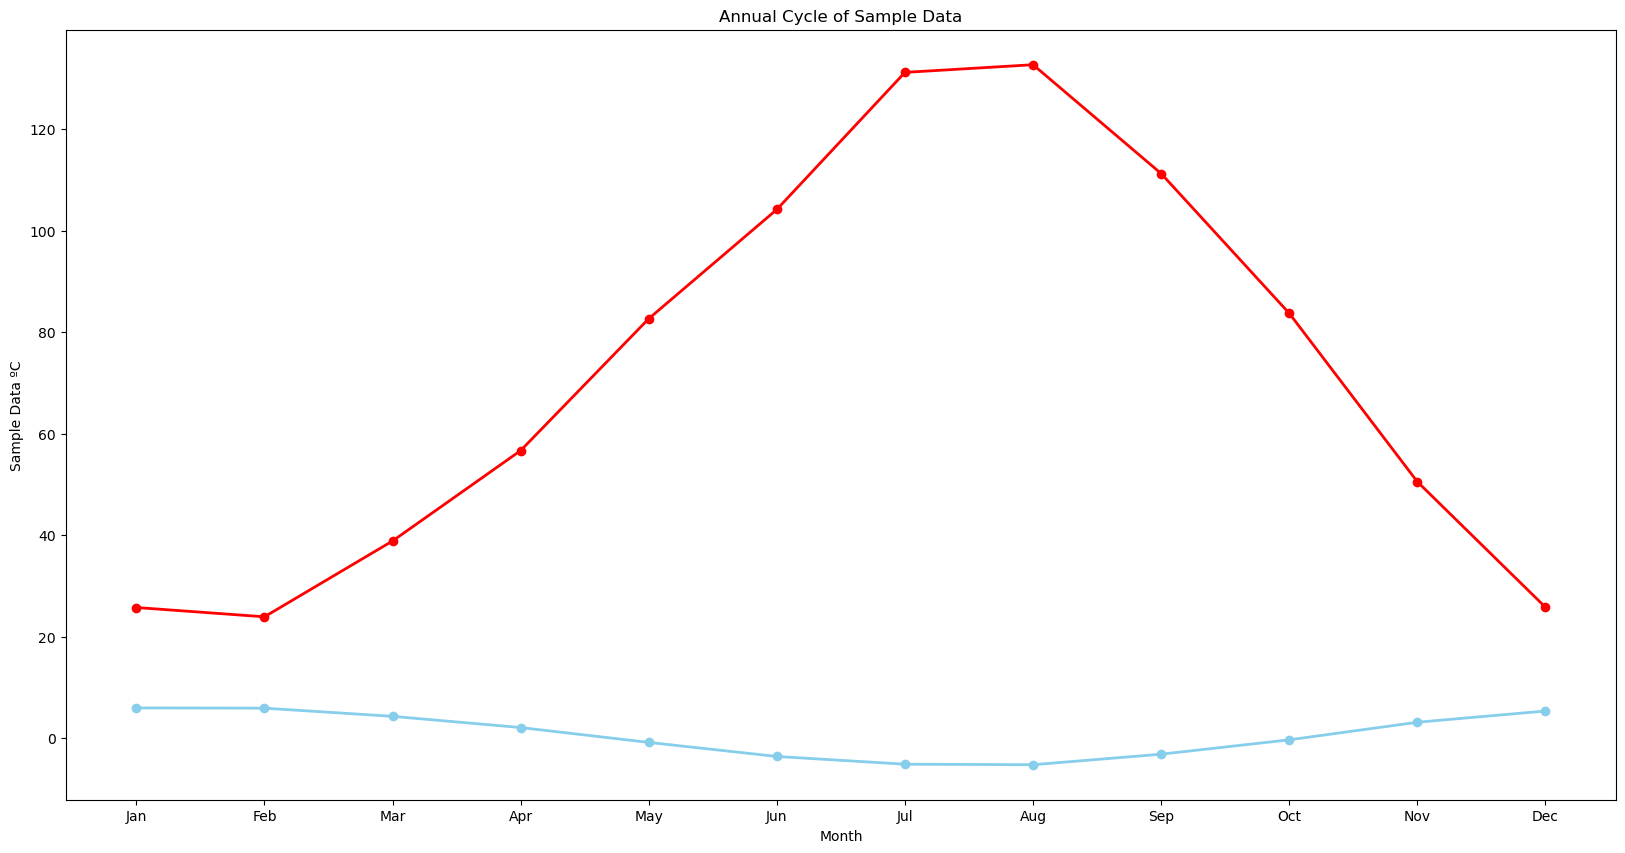

In [21]:
fig=plot_time_series(ds_var, variable,urban_vicinity,time_series,data_squares=False)
